# Beginning

In [4]:
import numpy as np
import pandas as pd
from numpy.random import rand
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math
import uproot
import array
import random
import gc
import numba
from numba import jit
import pickle5 as pickle
import os

In [5]:
SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26
pkljar = '/PickleJar/'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
Blake = '/SiPMMonitor/Blake/'

In [215]:
def efficiencyCalc(nums, trials, poissonbool=False, binomialbool = True):
    #This will calculate the efficiency in the SQ (often the E) detector 
    #with no threshold settings on the Trigger detector
    
    x = np.linspace(0,1.022,512)
    eff = []
    poierr = []
    binerr = []
    for i in x:
        num = nums[nums.detSQ_En > i].shape[0]
        eff.append(num / trials * 100)#percent
        if poissonbool == True:
            poierr.append(np.sqrt(num**2 * (trials + num)/trials**3)*100)
        if binomialbool == True:
            binerr.append(np.sqrt(num * (1-num/trials)/trials**2)*100)
        else:
            continue

        
    if binomialbool==True:
        binerr = np.array(binerr)
        if poissonbool == True:
            poierr = np.array(poierr)
            return eff, binerr, poierr
        else:
            return eff, binerr
    elif poissonbool==True:
        poierr = np.array(poierr)
        return eff,poierr
    else:
        return eff
def efficiencyCalc2(nums, trials, poissonbool=False, binomialbool = True):
    #This will calculate the efficiency in the SQ (often the E) detector 
    #with threshold equivalent settings on the Trigger detector
    x = np.linspace(0,1.022,512)
    eff = []
    poierr = []
    binerr = []
    for i in x:
        num = nums[(nums.detSQ_En > i) & (nums.detTrig_En > i)].shape[0]
        eff.append(num / trials * 100)#percent
        if poissonbool == True:
            poierr.append(np.sqrt(num**2 * (trials + num)/trials**3)*100)
        if binomialbool == True:
            binerr.append(np.sqrt(num * (1-num/trials)/trials**2)*100)
        else:
            continue

        
    if binomialbool==True:
        binerr = np.array(binerr)
        if poissonbool == True:
            poierr = np.array(poierr)
            return eff, binerr, poierr
        else:
            return eff, binerr
    elif poissonbool==True:
        poierr = np.array(poierr)
        return eff,poierr
    else:
        return eff
    
def efficiencyCalc3(nums, trials,trig, poissonbool=False, binomialbool = True):
    #This will calculate the efficiency in the SQ (often the E) detector 
    #with individual threshold setting on the Trigger detector
    x = np.linspace(0,1.022,512)
    eff = []
    poierr = []
    binerr = []
    for i in x:
        num = nums[(nums.detSQ_En > i) & (nums.detTrig_En > trig/1000)].shape[0]
        eff.append(num / trials * 100)#percent
        if poissonbool == True:
            poierr.append(np.sqrt(num**2 * (trials + num)/trials**3)*100)
        if binomialbool == True:
            binerr.append(np.sqrt(num * (1-num/trials)/trials**2)*100)
        else:
            continue

        
    if binomialbool==True:
        binerr = np.array(binerr)
        if poissonbool == True:
            poierr = np.array(poierr)
            return eff, binerr, poierr
        else:
            return eff, binerr
    elif poissonbool==True:
        poierr = np.array(poierr)
        return eff,poierr
    else:
        return eff
def load2root(infile, outfile, outbool = False, readnum=15, dropcols = ['']):
    # load the multithreaded files into a single file
    # cut down data size by only including those that deposit energy in the SQ detector
    # maintain the initial energy 
    data = uproot.open(infile)["simData"]
    data = data.arrays(filter_name = "*", library = 'pd')
    counts =    data.shape[0]
    data = data[ (data.detSQ_En >0)]
    try:
        data = data.drop(columns = dropcols)
    except:
        print("dropcols didn't work")
    data, dataCounts = unpackfull(infile[-9], data, True, infile[:-9], readnum, counts, dropcols)#1B
    del counts
    gc.collect()
    
    with uproot.recreate(outfile) as file:
        file.commpression = uproot.ZLIB(6)
        file["Tree"] = data
        file["Size"] = str(dataCounts)
    fstat = os.stat(outfile)
    print(f'File size of {outfile} in GB is {fstat.st_size / (1024*1024*1024)}')
    gc.collect()
    print(data.head())
    print(dataCounts)
    print(data[data.detSQ_En >0].shape[0]/dataCounts * 100, '%')    
    if outbool == True:
        return data, dataCounts
    else:
        return         

def unpackfull (num, df, first, iso, threads, count, dropcols):
    try:
        df = pd.read_pickle(f'{pkljar}{iso}{num}.pkl')
    except:    
        if (first == True):
            for i in range(threads):
                k = i+1
                temp =  uproot.open(f'{iso}{num}Th{k}.root')["simData"]
                temp = temp.arrays(filter_name = "*", library = 'pd')
                try:
                    temp = temp.drop(columns = dropcols)
                except:
                    print("dropcols didn't work")
#                 temp=temp.drop(columns = ['detSQ_Hit',#'detSQ_InEn','detSQ_ID',# 'detSQ_x', 'detSQ_y',
# #                                     'detSQ_z', 'detSQ_t',
#                     #'detRT_Hit','detRT_InEn','detRT_En', 'detRT_ID'#'detRT_x', 'detRT_y', 'detRT_z',
#                     #'detRT_t', 'detRT_Inx', 'detRT_Iny', 'detRT_Inz',
#                                      #'detSQ_Inx', 'detSQ_Iny', 'detSQ_Inz'
#                                          ])
                count = count + temp.shape[0]
                temp = temp[temp.detSQ_En >0]
                gc.collect()
                df = df.append(temp, ignore_index=True)
                del temp
                gc.collect()
        else:
            for i in range(threads+1):
                temp =  uproot.open(f'{iso}{num}Th{i}.root')["simData"]
                temp = temp.arrays(filter_name = "*", library = 'pd')
                df = df.append(temp, ignore_index=True)
    return df,count
    
def pmtfunc(temp, err):
    #Add noise to data
    a = err #/ (2*np.sqrt(2*np.log(2)))
    sigma = a * np.sqrt(temp.detSQ_En)
    sigma2 = a * np.sqrt(temp.detTrig_En)
    Y = temp.shape[0]
    sigma = np.where(sigma < 50/1000, 50/1000, sigma)
    sigma2 = np.where(sigma2 < 50/1000, 50/1000, sigma2)
    dev = (2* np.random.rand(Y)-1) * np.random.normal(size = Y, scale = a)
    dev2 = (2* np.random.rand(Y)-1) * np.random.normal(size = Y, scale = a)
    print(sigma)
    temp['pmtSQ_En'] = temp.detSQ_En + dev * sigma 
    temp['pmtTrig_En'] = temp.detTrig_En + dev2 * sigma2 
    return temp

In [216]:
NeTSiPMdata = uproot.open("SiPMMonitor/Blake/Ne/19NeTSiPM.root")["Tree"]
NeTSiPMdataCounts = int(uproot.open("SiPMMonitor/Blake/Ne/19NeTSiPM.root")["Size"])

NeTSiPMdata = NeTSiPMdata.arrays(filter_name = "*", library = 'pd')

In [218]:
uncert = 15.101402/1e3#spread of pmtfunc 15.101402, 8.1061664 kev-> MeV

NeTSiPMdata = pmtfunc(NeTSiPMdata,uncert)

[0.05 0.05 0.05 ... 0.05 0.05 0.05]


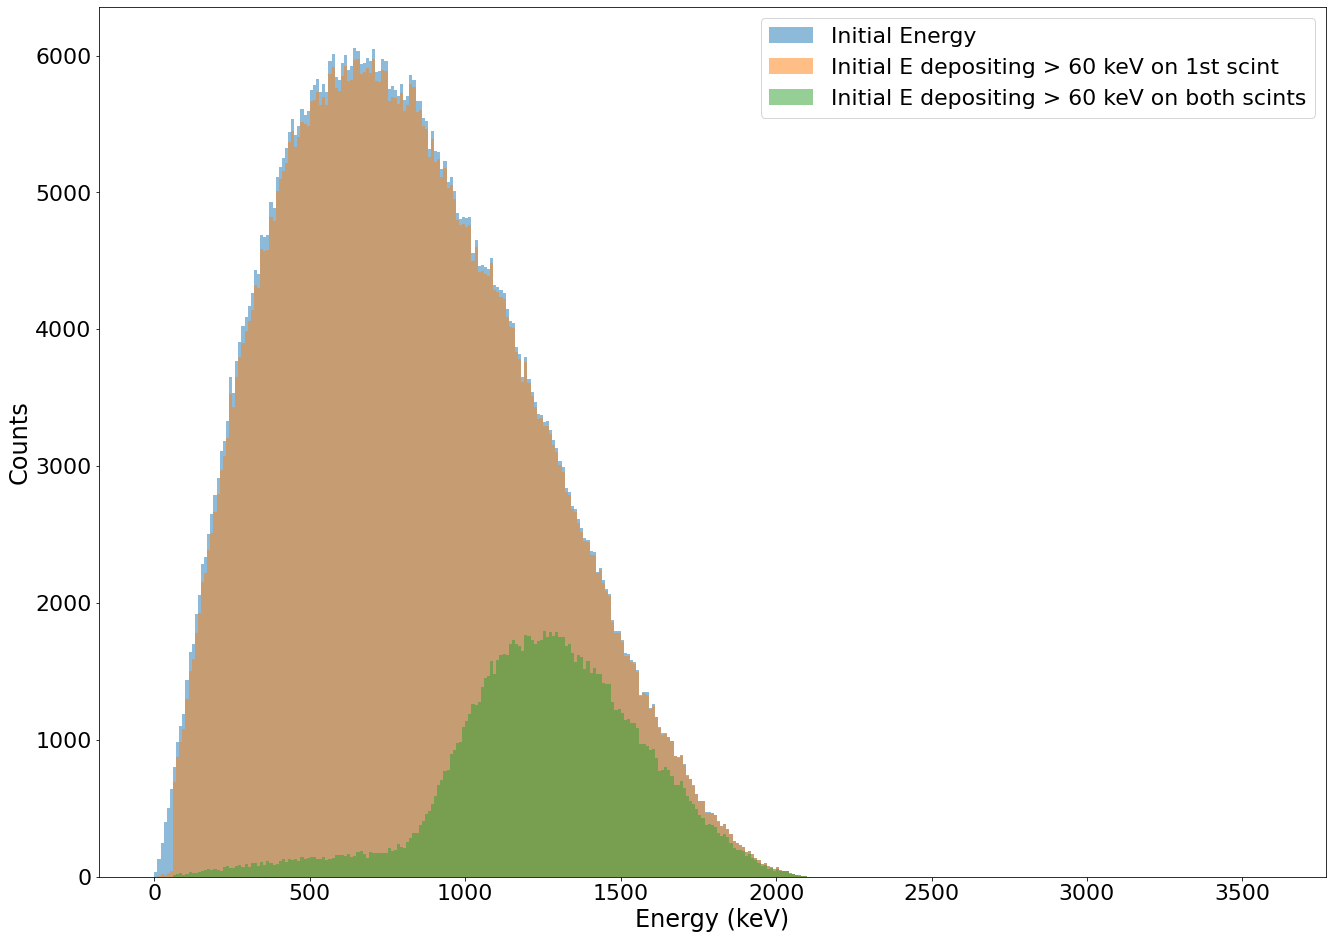

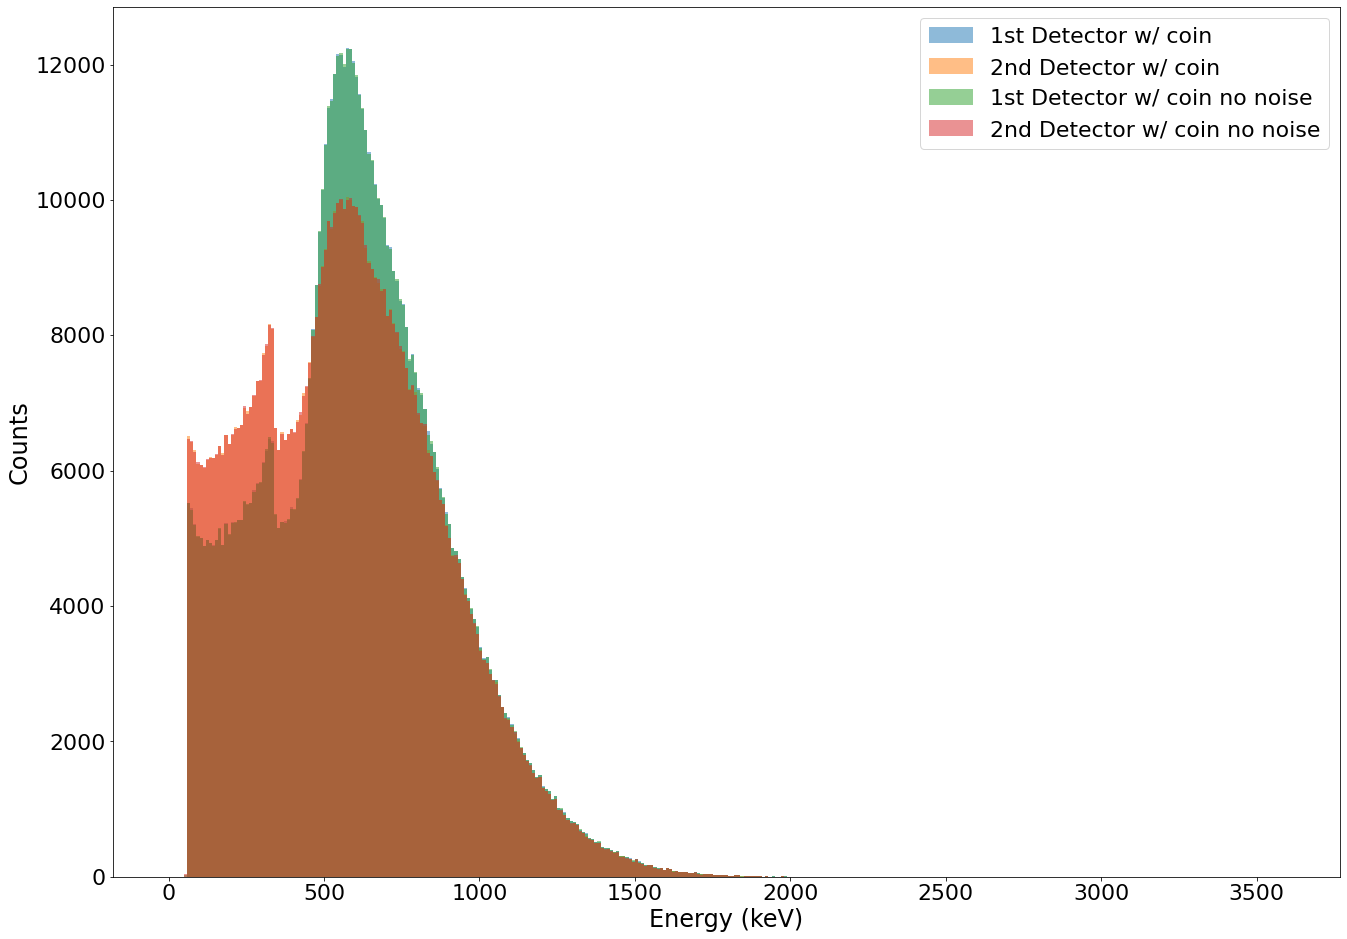

In [219]:
bins = np.arange(0,3600,10)
plt.figure(figsize=(22,16))
# plt.hist(NeTSiPMdata.detSQ_En[(NeTSiPMdata.detSQ_En>=.060)]*1000, bins, alpha = 0.5, density = False, label = '1st Scint')
# plt.hist(NeTSiPMdata.detTrig_En[(NeTSiPMdata.detTrig_En>.060)]*1000, bins, alpha = 0.5, density = False, label = '2nd Scint')


plt.hist(NeTSiPMdata.detVac_InEn[(NeTSiPMdata.detVac_ID==-11)]*1000, bins, alpha = 0.5, density = False, label = 'Initial Energy')
plt.hist(NeTSiPMdata.detVac_InEn[(NeTSiPMdata.detVac_ID==-11) & ((NeTSiPMdata.pmtSQ_En>=.060))]*1000, bins, alpha = 0.5, density = False, label = 'Initial E depositing > 60 keV on 1st scint')
# plt.hist(NeTSiPMdata.detVac_InEn[(NeTSiPMdata.detVac_ID==-11) & ((NeTSiPMdata.detTrig_En>=.060))]*1000, bins, alpha = 0.5, density = False, label = 'Vacuum hitting 2nd')
plt.hist(NeTSiPMdata.detVac_InEn[((NeTSiPMdata.detVac_ID==-11) & (NeTSiPMdata.pmtTrig_En>=.060)) & (NeTSiPMdata.detSQ_En>=.060)]*1000, bins, alpha = 0.5, density = False, label = 'Initial E depositing > 60 keV on both scints')

# plt.hist((NeTSiPMdata.detSQ_En[(NeTSiPMdata.detSQ_En>.060) & (NeTSiPMdata.detTrig_En>.060)]+NeTSiPMdata.detTrig_En[(NeTSiPMdata.detSQ_En>0) & (NeTSiPMdata.detTrig_En>0)])*1000, bins, alpha = 0.5, density = False, label = 'sum')

plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.legend(loc = 'best')
# plt.axvline(x=360)
# plt.yscale('log')
plt.show()

plt.figure(figsize=(22,16))

# plt.hist(NeTSiPMdata.pmtSQ_En[(NeTSiPMdata.pmtSQ_En > 0) ]*1000, bins, alpha = 0.5, density = False, label = '1st Detector no coin')
# plt.hist(NeTSiPMdata.pmtTrig_En[(NeTSiPMdata.pmtTrig_En > 0) ]*1000, bins, alpha = 0.5, density = False, label = '2nd Detector no coin')

plt.hist(NeTSiPMdata.pmtSQ_En[(NeTSiPMdata.pmtSQ_En > 0.06) & (NeTSiPMdata.pmtTrig_En > 0.06)]*1000, bins, alpha = 0.5, density = False, label = '1st Detector w/ coin')
plt.hist(NeTSiPMdata.pmtTrig_En[(NeTSiPMdata.pmtTrig_En > 0.06) & (NeTSiPMdata.pmtSQ_En > 0.06)]*1000, bins, alpha = 0.5, density = False, label = '2nd Detector w/ coin')


plt.hist(NeTSiPMdata.detSQ_En[(NeTSiPMdata.pmtSQ_En > 0.06) & (NeTSiPMdata.pmtTrig_En > 0.06)]*1000, bins, alpha = 0.5, density = False, label = '1st Detector w/ coin no noise')
plt.hist(NeTSiPMdata.detTrig_En[(NeTSiPMdata.pmtTrig_En > 0.06) & (NeTSiPMdata.pmtSQ_En > 0.06)]*1000, bins, alpha = 0.5, density = False, label = '2nd Detector w/ coin no noise')

plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.legend(loc = 'best')
# plt.axvline(x=360)
# plt.yscale('log')
plt.show()

# SiPM & Scintillator Response

In [24]:
#Photon Production
x1 = np.arange(400,423,0.01)
x2 = np.arange(450,520,0.01)
x3 = np.arange(423,450,0.01)
y1 =0.95*np.sin(np.pi/23*x1+0.4)/2+0.525
y2 = np.exp(-0.02559656384*x2+11.007628107)
y3 = -7.861915*10**(-5)*x3**3+0.103459*x3**2-45.3815*x3+6636.001
wavelength = np.concatenate((x1,x2,x3),axis=None)
Intensity = np.concatenate((y1,y2,y3),axis=None)
branch = []
branch.append(0)
max_random = sum(Intensity)
for i in range(len(Intensity)):
    branch.append(Intensity[i]+branch[i])
branch = np.array(branch)

In [166]:
@numba.njit
def edep2Phot(df):
    r"""Some function
    
    Does some stuff.
    
    """

    newdat = pd.DataFrame(columns = column_names)
    for i in range(df.shape[0]):
        num_photons = round(df.iloc[i].detSQ_En *10000)
        rand = rng.random(num_photons)*max_random
        indexnum = np.full(num_photons,i)
        dat = pd.DataFrame(index = range(num_photons),data={'Raw':rand,'index':indexnum})
        dat['Wavelength'] = dat['Raw'].apply(photProduction)
        newdat = pd.concat([newdat, dat])
    return newdat


#Photon Acceptance
acceptance = -0.0016*wavelength**2+1.4267*wavelength-267.81
@numba.njit
def SiPMAcceptance(df):
    r"""Some function
    
    Does some stuff.
    
    """
    newdat = pd.DataFrame(columns = column_names)
    for i in range(len(wavelength)):
        temp = df[df['Wavelength'] == wavelength[i]]
        temp = temp.sample(frac = acceptance[i])
        newdat = pd.concat([newdat, temp])
    return newdat

@numba.jit
def SiPMAcceptance2(arr):
    r"""Some function
    
    Does some stuff.
    
    """
    newarr = np.array([0])
    for i in range(len(wavelength)):
        temp = arr[arr == wavelength[i]]
        temp = np.random.choice(temp, round(acceptance[i]*temp.shape[0]))
        newarr = np.concatenate((newarr, temp), axis=None)
    return sum(1239.8/newarr[1:])/1e6

@numba.jit
def edep2Phot2(num_photons):
    r"""Some function
    
    Does some stuff.
    
    """
    rand = rng.random(int(num_photons))*max_random
    rand = np.array(rand)
    for i in range(rand.shape[0]):
        rand[i] = photProduction(rand[i])
    newarr = np.array([0])
    print('sum', sum(1239.8/rand)/1e6, 'and orig ', num_photons/10000)
    for j in range(len(wavelength)):
        temp = rand[rand == wavelength[j]]
        #print(acceptance[j])
        temp = np.random.choice(temp, math.ceil(acceptance[j]*temp.shape[0]))
        #print(temp.shape[0])
        newarr = np.concatenate((newarr, temp), axis=None)
    print(newarr.shape[0]/int(num_photons))
    return sum(1239.8/newarr[1:])/1e6
    #return rand


@numba.njit
def photProduction(x):
    r"""Return photon production wavelengths"""
    if x <=branch[len(branch)-1]:
        for i in range(len(branch)):
            if x <= branch[i+1]:
                return wavelength[i]
    else:
        return wavelength[len(branch)-1]

def line(x,m,b):
    return m * x + b

def quad(x,a,b,c):
    return a * x**2 + b * x + c

def cube(x,a,b,c,d):
    return a * x**3 + b * x**2 + c * x + d

def gaussian(x,a,b,c):
    return a * np.exp(-(x-b)**2/(2*c**2))
def exponential(x,a,b,c,d,e):
    return a * np.exp(b*x**c+d)+e

20

In [37]:
en = 1000000 # Energy in eV
num_trials = int(en *.01)
rng = np.random.default_rng()
rand = rng.random(num_trials)*max_random
dat = pd.DataFrame(index = range(num_trials),data={'Raw':rand})
dat['Wavelength'] = dat['Raw'].apply(photProduction)

In [39]:
acceptance = (-0.0016*wavelength**2+1.4267*wavelength-267.81)/100
column_names = ["Raw", "Wavelength", "Energy"]
newdat = pd.DataFrame(columns = column_names)
for i in range(len(wavelength)):
    temp = dat[dat['Wavelength'] == wavelength[i]]
    temp = temp.sample(frac = acceptance[i])
    newdat = pd.concat([newdat, temp])

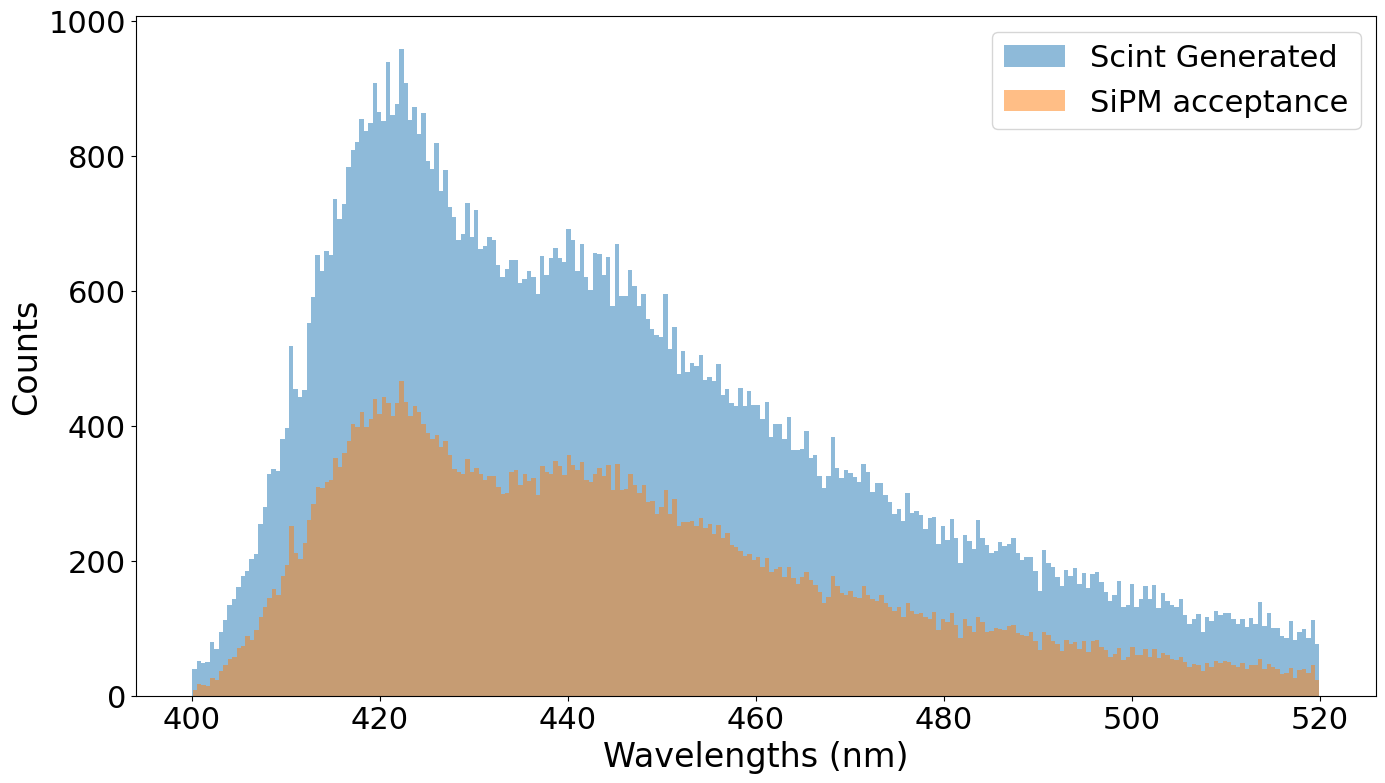

In [44]:
fig,ax =plt.subplots(figsize=(16,9),dpi = 100)
ax.set_xlabel('Wavelengths (nm)')
ax.set_ylabel('Counts')
ax.hist(x = dat['Wavelength'],bins = 256, alpha = 0.5, label = 'Scint Generated')
ax.hist(x = newdat['Wavelength'],bins = 256, alpha = 0.5, label = "SiPM acceptance")
plt.legend(loc='best')
plt.show()
print('Acceptance', sum(1239.8/newdat['Wavelength'])/en * 100, '%')
print('Scint Generation', sum(1239.8/dat['Wavelength'])/en * 100, '%')

In [66]:
inEn = np.arange(0,1000000,1000)

column_names = ["Raw", "Wavelength", "Energy"]
outEn = []
acceptance = (-0.0016*wavelength**2+1.4267*wavelength-267.81)/100

for en in inEn:
    num_trials = int(en *.01)
    rng = np.random.default_rng()
    rand = rng.random(num_trials)*max_random
    dat = pd.DataFrame(index = range(num_trials),data={'Raw':rand})
    dat['Wavelength'] = dat['Raw'].apply(photProduction)
    
    newdat = pd.DataFrame(columns = column_names)
    for i in range(len(wavelength)):
        temp = dat[dat['Wavelength'] == wavelength[i]]
        temp = temp.sample(frac = acceptance[i])
        newdat = pd.concat([newdat, temp])
    outEn.append(sum(1239.8/newdat['Wavelength']))
outEn = np.array(outEn)

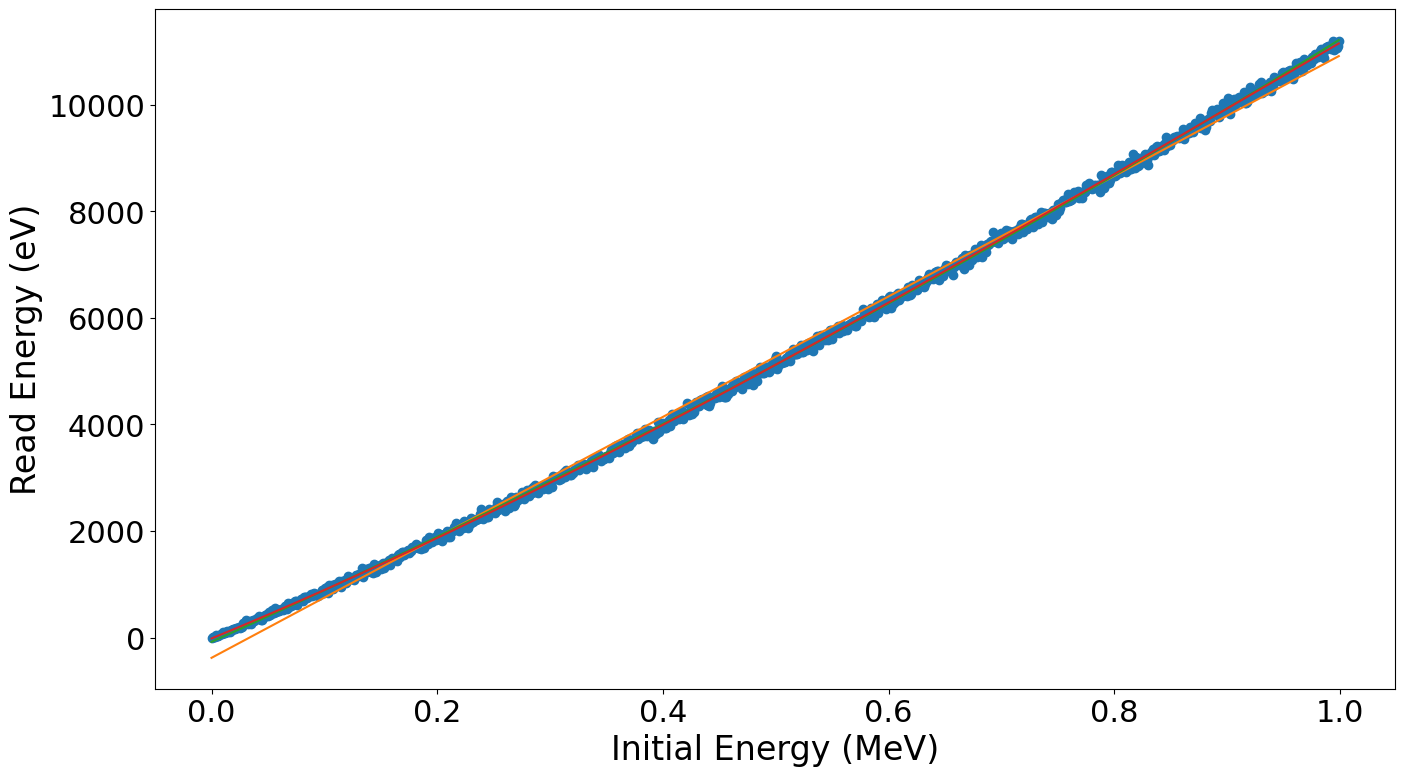

0.011304177255204273x + -380.99461790894986
1.8077349648258539e-09x^2 + 0.009498250001640651x+-80.6087048012723
-1.272601864238456e-15x^3 + 3.7147286932060733e-09x^2+0.008736596582953247x+-17.35974126993905


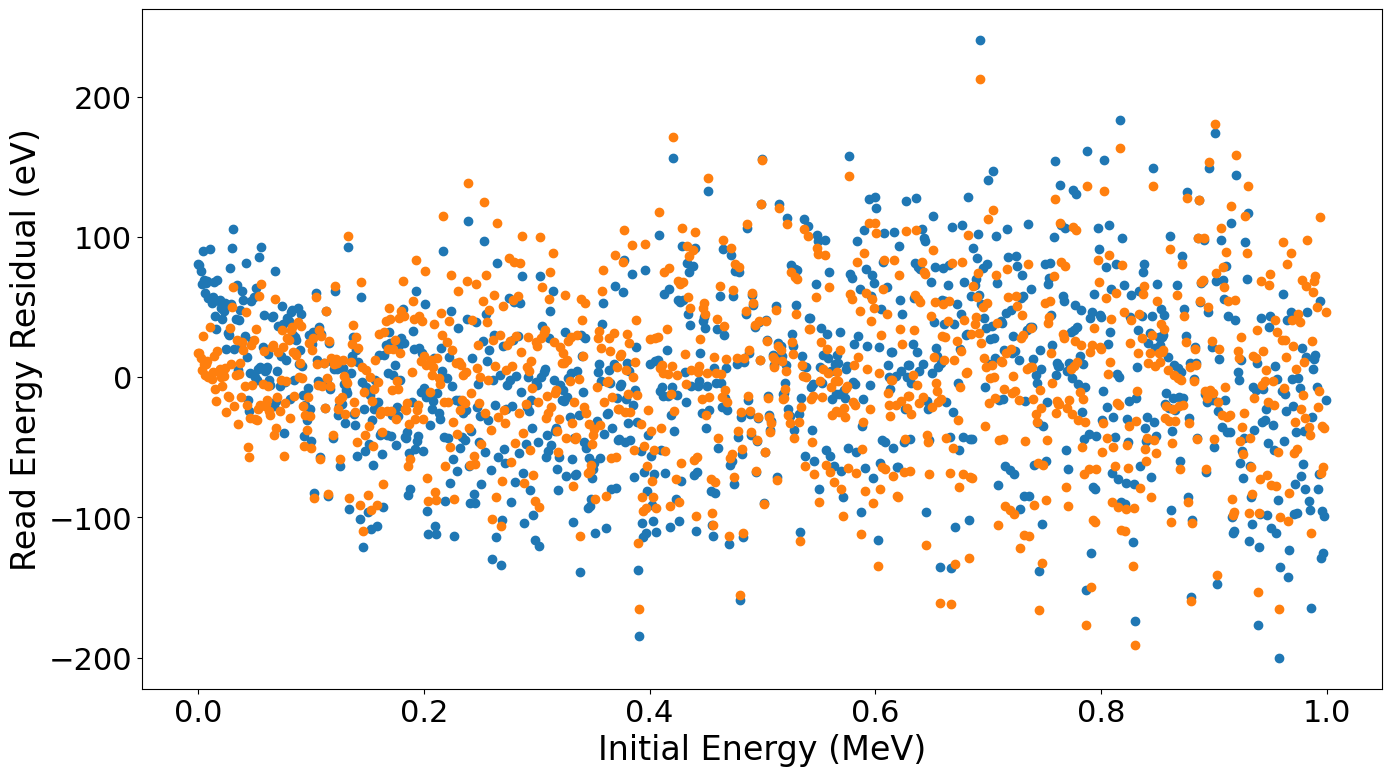

In [170]:
fig,ax =plt.subplots(figsize=(16,9),dpi = 100)
plt.plot(inEn/1e6,outEn, 'o')
popt, pcov = curve_fit(line, inEn, outEn)
popt2, pcov2 = curve_fit(quad, inEn, outEn)
popt3, pcov3 = curve_fit(cube, inEn, outEn)
# popte, pcove = curve_fit(exponential, inEn, outEn)
plt.plot(inEn/1e6, line(inEn, *popt))
plt.plot(inEn/1e6, quad(inEn, *popt2))
plt.plot(inEn/1e6, cube(inEn, *popt3))
# plt.plot(inEn/1e6, exponential(inEn, *popte))
plt.xlabel('Initial Energy (MeV)')
plt.ylabel('Read Energy (eV)')
plt.show()
print(f'{popt[0]}x + {popt[1]}')
print(f'{popt2[0]}x^2 + {popt2[1]}x+{popt2[2]}')
print(f'{popt3[0]}x^3 + {popt3[1]}x^2+{popt3[2]}x+{popt3[3]}')
# print(f'{popte[0]}e^({popte[1]}x^({popte[2]})+{popte[3]})+{popte[4]}')
fig,ax =plt.subplots(figsize=(16,9),dpi = 100)
plt.plot(inEn/1e6,outEn - quad(inEn, *popt2) , 'o')
plt.plot(inEn/1e6,outEn - cube(inEn, *popt3) , 'o')
# plt.plot(inEn/1e6,outEn - exponential(inEn, *popte) , 'o')
# plt.plot(inEn/1e6,outEn - line(inEn, *popt) , 'o')
# plt.plot(inEn/1e6, line(inEn, *popt))
# plt.plot(inEn/1e6, quad(inEn, *popt2))
plt.xlabel('Initial Energy (MeV)')
plt.ylabel('Read Energy Residual (eV)')
plt.show()



1.0
quad sigma = 63.240450941716624 eV
cube sigma = 53.70398112077726 eV


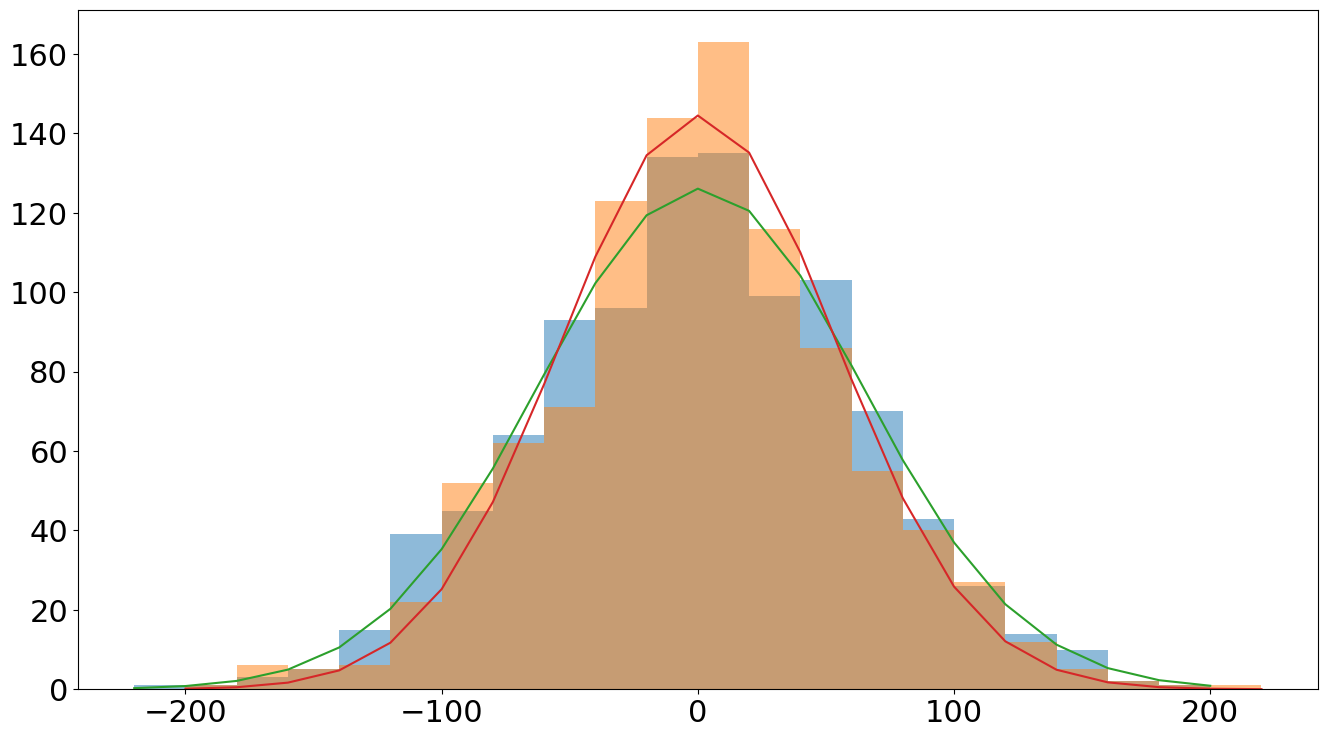

In [168]:
bino = np.arange(-220,240,20)
xcenters = (bino[:-1] + bino[1:]) / 2

fig,ax =plt.subplots(figsize=(16,9),dpi = 100)
quadhist = plt.hist(outEn-quad(inEn,*popt2), bins = bino, alpha = 0.5, label = 'quadratic')
cubehist = plt.hist(outEn-cube(inEn,*popt3), bins = bino, alpha = 0.5, label = 'cubic')

popthq, pcovhq = curve_fit(gaussian,quadhist[1][1:],quadhist[0])
popthc, pcovhc = curve_fit(gaussian,cubehist[1][:-1],cubehist[0])
plt.plot(quadhist[1][:-1], gaussian(xcenters, *popthq), label = 'quad fit')
plt.plot(cubehist[1][1:], gaussian(xcenters, *popthc), label = 'cube fit')
print(f'quad sigma = {popthq[2]} eV')
print(f'cube sigma = {popthc[2]} eV')

print(f'{popt2[0] }x^2 + {popt2[1]}x+{popt2[2]}')
print(f'{popt3[0]}x^3 + {popt3[1]}x^2+{popt3[2]}x+{popt3[3]}')

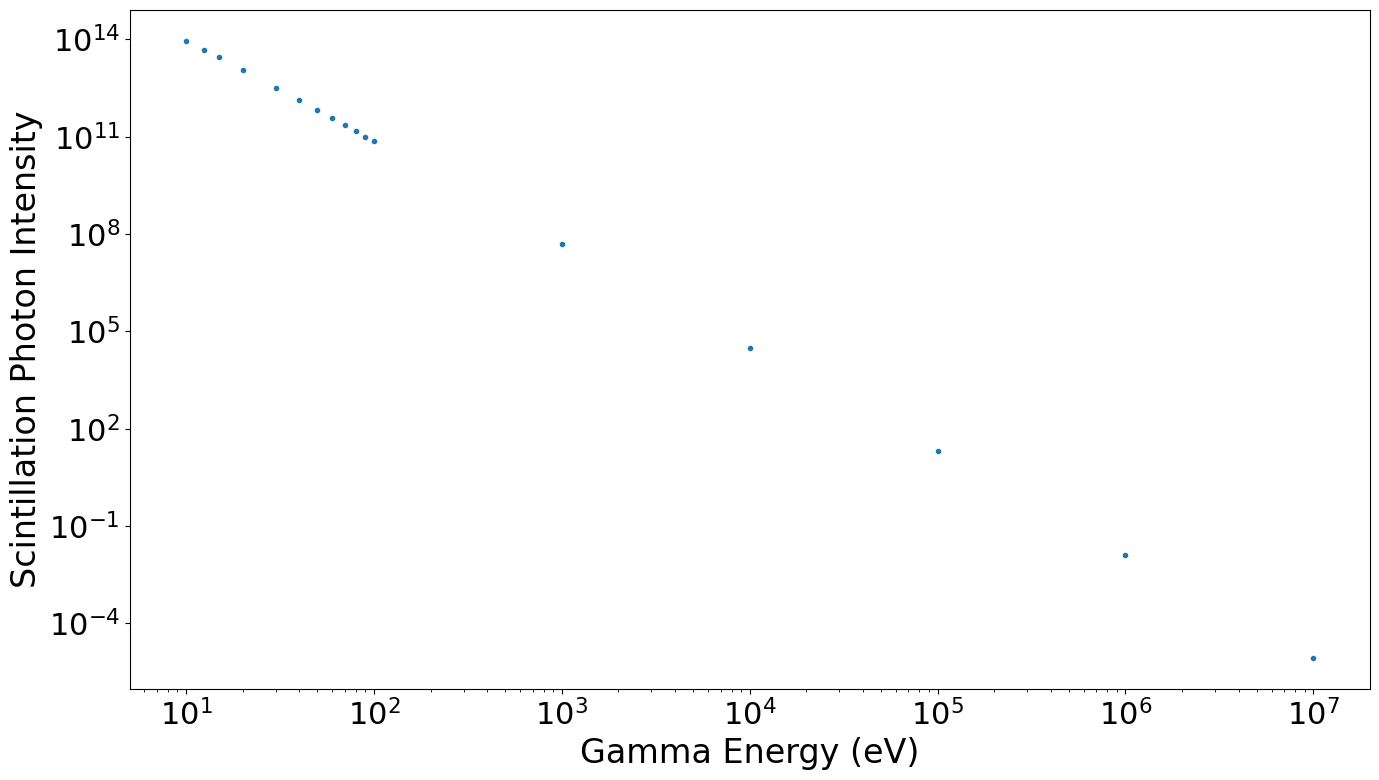

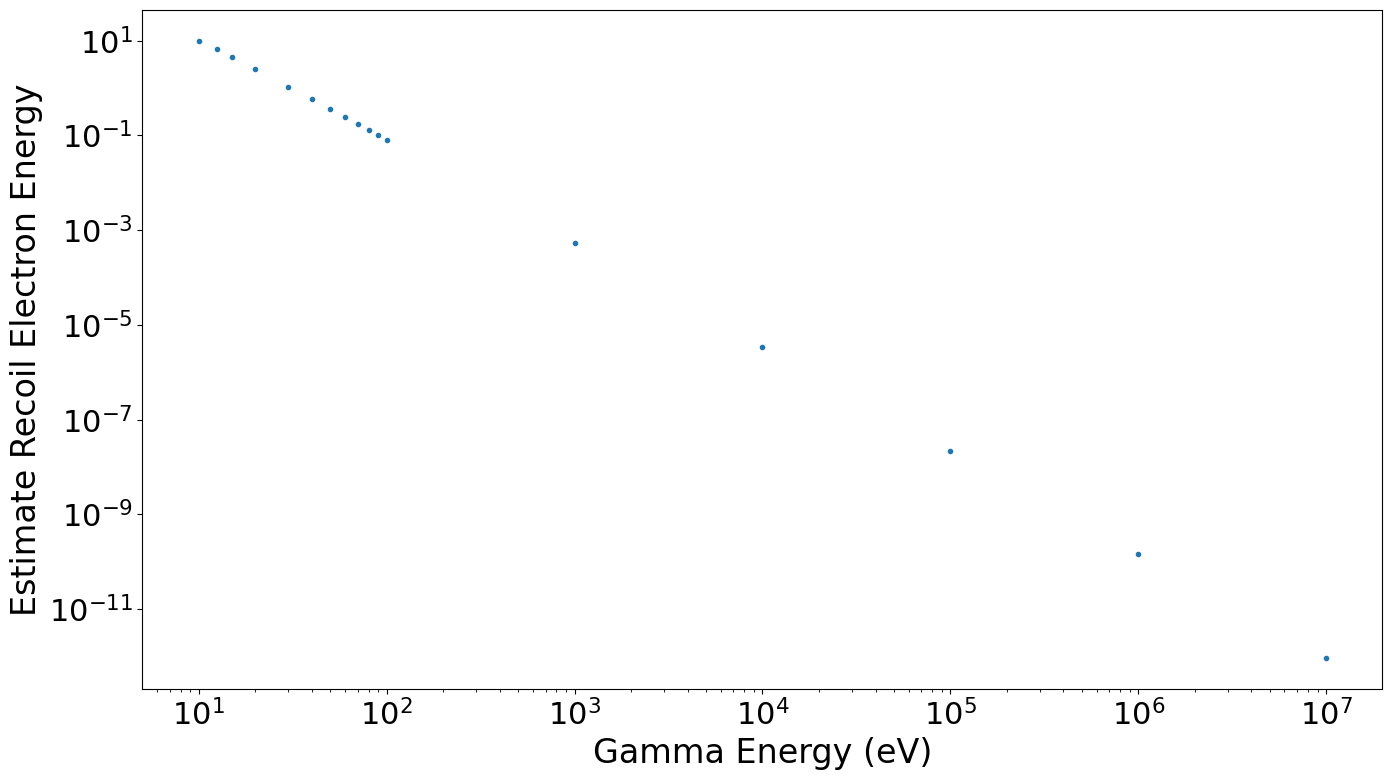

In [172]:
Enarr = np.array([10,12.5,15,2e1,3e1,4e1, 5e1, 6e1, 7e1,8e1,9e1,1e2,1e3,1e4,1e5,1e6,1e7])
Io = 1

mec2 = 510998.9461#eV

rho = 1.023#EJ-212 Density g/cc -> u/cc
d = .5# scint thickness cm
Z = (1.00784 * (5.17) + 12.011 * (4.69))/(5.17+4.69)
n = 3.5 # some value between 3 and 4


Intenarr = []
for Eo in Enarr:
    Inten = Io * np.exp(-rho * d * (Z**n/Eo**(7/2)+1/(Eo**(1/2))+Z*math.log(2*Eo/mec2)))
    Intenarr.append(Inten)
Intenarr = np.array(Intenarr)

fig,ax =plt.subplots(figsize=(16,9),dpi = 100)
plt.plot(Enarr, Intenarr, '.')
plt.xlabel('Gamma Energy (eV)')
plt.ylabel('Scintillation Photon Intensity')
plt.yscale('log')
plt.xscale('log')
plt.show()

fig,ax =plt.subplots(figsize=(16,9),dpi = 100)
plt.plot(Enarr, Enarr * Intenarr/Intenarr[0], '.')
plt.xlabel('Gamma Energy (eV)')
plt.ylabel('Estimate Recoil Electron Energy')
plt.yscale('log')
plt.xscale('log')
plt.show()

(array([5.90000e+01, 1.78000e+03, 2.14630e+04, 1.01549e+05, 1.89845e+05,
        1.39255e+05, 4.11020e+04, 4.73100e+03, 2.11000e+02, 5.00000e+00]),
 array([-2.57678606, -2.02524358, -1.4737011 , -0.92215862, -0.37061614,
         0.18092634,  0.73246882,  1.2840113 ,  1.83555378,  2.38709626,
         2.93863874]),
 <BarContainer object of 10 artists>)

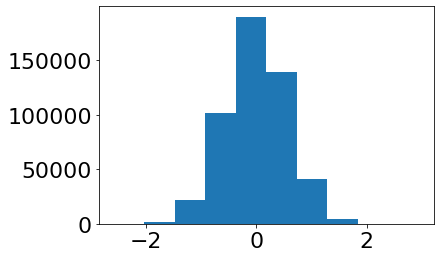

In [88]:
plt.hist(np.random.normal(size = 500000, scale = uncert))

# Bottom